# Multilateration Examples

Two simple example using multilateration to embed Hamming graphs and biological sequences. This notebook is available as part of the [ACM-BCB 2019 tutorial on GitHub.](https://github.com/riti4538/ACM-BCB-2019-Tutorial)

For more information on metric dimension see:

- Chartrand, Gary, et al. [Resolvability in graphs and the metric dimension of a graph.](https://www.sciencedirect.com/science/article/pii/S0166218X00001980) *Discrete Applied Mathematics* 105.1-3 (2000): 99-113.

The paper introducing multilateration:

- Tillquist, Richard C., and Manuel E. Lladser. [Low-dimensional representation of genomic sequences.](https://link.springer.com/article/10.1007/s00285-019-01348-1) *Journal of Mathematical Biology* (2019): 1-29.

Python code implementing the [Information Content Heuristic (ICH) algorithm](https://www.sciencedirect.com/science/article/pii/S1570866711001134) as well as a constructive algorithm for finding resolving sets of Hamming graphs is available [here.](https://github.com/riti4538/Multilateration)

In [2]:
import numpy as np
from scipy.special import comb
from itertools import combinations, product
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from multilateration import checkResolving, hammingDist, ich

## Embedding Codons

To start, we will generate an embedding of DNA 3-mers using multilateration. In this case, using the Hamming distance directly to compare 3-mers may not work well. Indeed, since we know the [mapping from codons to amino acids](https://en.wikipedia.org/wiki/DNA_codon_table), it seems reasonable to include this information in defining differences between codons. Instead of looking at all pairs of codons individually, we will augment the definition of Hamming distance between codons with weights at each position. With a vector of weights $\mathbf{w}$, our distance function between codons $X$ and $Y$ is

$$d(X, Y) = \sum_{i=1}^3 \mathbf{w}_i \cdot [\![ x_i = y_i ]\!].$$

Furthermore, it is easy to see that the only variable position in codons coding for the same amino acid is the [3rd nucleotide](https://genomevolution.org/wiki/index.php/Codon_wobble_positions). So we will set $\mathbf{w} = (2,2,1)$ and perform multilateration with the resulting pairwise distances.

In [3]:
#generate a similarity matrix for codons given a list of weights
#weights give a value to multiply the Hamming distance by for each index
#e.g. for weights = [3,2,1], d(ATC, TGG) = 3*1+2*1+1*1 = 6
#     and d(ATC, ACC) = 3*0+2*1+1*0 = 2
def codonSimilarityMatrix(weights):
    if len(weights)<3: weights += [1 for _ in range(3-len(weights))]
    dist = lambda a,b: sum(w for (x,y,w) in zip(a,b,weights) if x!=y)
    codons = list(product(['A', 'C', 'G', 'T'], repeat=3))
    M = [[dist(A,B) for B in codons] for A in codons]
    return M

weights = [2, 2, 1]
M = codonSimilarityMatrix(weights)

Now we collect random resolving sets of the codon similarity matrix and use one of them to create an embedding.

In [4]:
#find up to maxNum random resolving sets of a codon similarity matrix
def codonResolvingSets(M, size=-1, maxNum=1, verbose=False):
    resSets = {}
    codons = list(product(['A', 'C', 'G', 'T'], repeat=3))
    total = max(comb(64, size), 1000)
    i = 0
    while len(resSets)<maxNum and i<total:
        if verbose and i%1000==0: print('num res sets found: ', len(resSets), 'i', i)
        i += 1
        R = randomCombo(3, ['A', 'C', 'G', 'T'], size)
        Ri = [codons.index(r) for r in R]
        if checkResolving(Ri, M):
            resSets[R] = 1
            if len(resSets)>=maxNum: return list(resSets)
    return list(resSets)

#generate a random set of kmers
def randomCombo(k, alphabet, size):
    kmers = product(alphabet, repeat=k)
    pool = tuple(kmers)
    n = len(pool)
    indices = sorted(np.random.choice(range(n), size=size, replace=False))
    return tuple(pool[i] for i in indices)

#determine the multilateration based embedding of codons based on a given set and similarity matrix
def codonEmbedding(M, R):
    locs = {}
    codons = list(product(['A', 'C', 'G', 'T'], repeat=3))
    for codon in codons:
        locs[''.join(codon)] = [M[codons.index(r)][codons.index(codon)] for r in R]
    return locs

beta = len(ich(M, randOrder=True))
RList = codonResolvingSets(M, size=beta, maxNum=10, verbose=False)

Finally, we visualize the result using the scikit-learn implementation of [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (t-distributed Stochastic Neighbor Embedding).

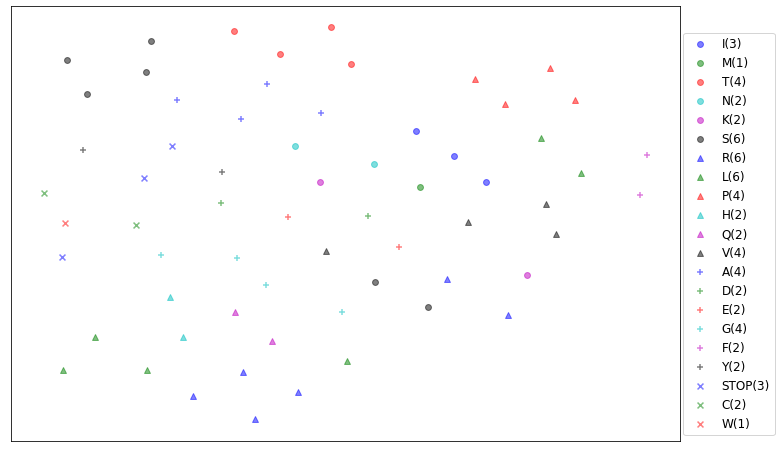

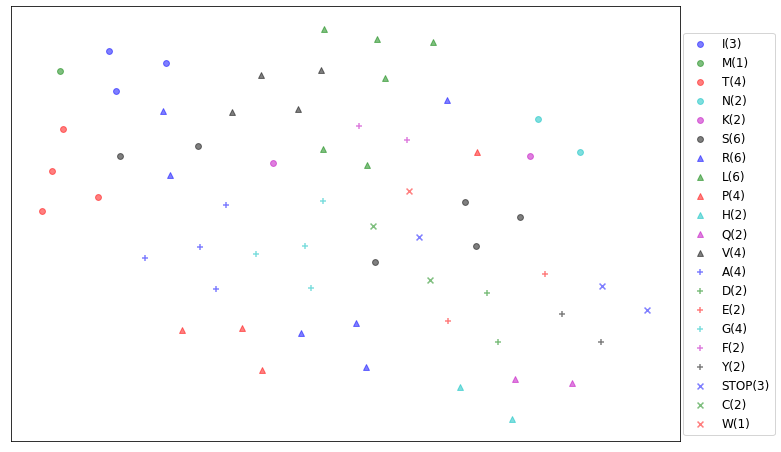

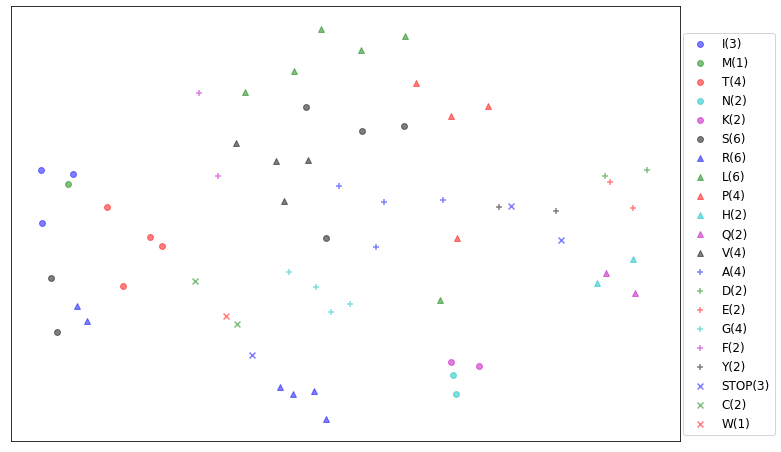

In [5]:
#use t-SNE to generate a simple visualization of a given embedding
#groups is a dictionary of label -> [kmers]
def visualize(locs, groups, textLabels={}, legend=True):
    kmers = sorted(list(locs))
    tsne = TSNE(n_components=2, init='pca')
    (X, Y) = zip(*tsne.fit_transform([locs[kmer] for kmer in kmers]))
    colors = ['b', 'g', 'r', 'c', 'm', 'k']
    markers = ['o', '^', '+', 'x', '*']
    symb = [(c,m) for m in markers for c in colors]
    plt.figure(figsize=(12,8))

    #plot kmers in the same group together with a common symbol/color
    for i,label in enumerate(groups):
        groupX = [X[kmers.index(kmer)] for kmer in groups[label]]
        groupY = [Y[kmers.index(kmer)] for kmer in groups[label]]
        plt.scatter(groupX, groupY, s=35, c=symb[i][0], marker=symb[i][1], label=label+'('+str(len(groups[label]))+')', alpha=0.5)
    
    #add any text labels
    for kmer in textLabels:
        plt.annotate(textLabels[kmer], xy=(X[kmers.index(kmer)], Y[kmers.index(kmer)]), xytext=(0,0), textcoords='offset points')

    ax = plt.gca()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.legend(bbox_to_anchor=(1.15,0), loc='lower right', prop={'size':12})
    plt.show()

codonMap = {'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M', 'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K', 'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L', 'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q', 'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V', 'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E', 'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S', 'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
            'TAC':'Y', 'TAT':'Y', 'TAA':'STOP', 'TAG':'STOP', 'TGC':'C', 'TGT':'C', 'TGA':'STOP', 'TGG':'W'}
aaMap = {}
for kmer in codonMap:
    aa = codonMap[kmer]
    if aa not in aaMap: aaMap[aa] = []
    aaMap[aa].append(kmer)

for _ in range(3):
    locs = codonEmbedding(M, RList[np.random.choice(len(RList))])
    visualize(locs, aaMap, legend=True)

## Embedding Large Hamming Graphs

Metric dimension can also be useful for generating embeddings of very large Hamming graphs. Consider $H_{8,20}$, the Hamming graph over amino acid sequences of length $20$. This graph has $20^8 = 25.6$ billion vertices and is far too large to be fully embedded using techniques like [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) or [Node2Vec](https://snap.stanford.edu/node2vec/).

Approximating $\beta(H_{8,20})$, the metric dimension of this graph, using the ICH algorithm is also impractical. However, we can find a small resolving set for the graph using the [constructive proof of the bound](https://link.springer.com/article/10.1007/s00285-019-01348-1)

$$\beta(H_{k,a}) \leq \beta(H_{k+1,a}) \leq \beta(H_{k,a}) + \lfloor a/2 \rfloor.$$

To start, we will apply the ICH algorithm to approximate $\beta(H_{2,20})$. 

In [6]:
AA = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
seqs = [''.join(s) for s in list(product(AA, repeat=2))]
M = [[hammingDist(a,b) for b in seqs] for a in seqs]
R = [seqs[i] for i in ich(M, randOrder=True)]
print('The metric dimension of H_{2,20} is at most '+str(len(R)))

The metric dimension of H_{2,20} is at most 28


Next we apply the constructive algorithm $6$ times. This algorithm takes advantage of the following structure in the distance matrix $D$ of $H_{k+1,a}$ where $d$ is the distance matrix of $H_{k,a}$ and $\mathbf{1}$ is the matrix of all 1s.

$$D = \begin{pmatrix} d & d+\mathbf{1} & \dots & d+\mathbf{1} \\ d+\mathbf{1} & d & \dots & d+\mathbf{1} \\ \vdots & \vdots & \ddots & \vdots \\ d+\mathbf{1} & d+\mathbf{1} & \dots & d \end{pmatrix}$$

Here the submatrix $d+\mathbf{1}$ appears $(a-1)$ times in each row and column while the submatrix $d$ appears once in each row along the diagonal.

On each iteration this algorithm adds $\frac{a}{2}$ elements to the resolving set. Intuitively, these new vertices guarantee that there no two vertices with a different first character can be at the same distance from every element of the resolving set. The remaining vertices ensure that no two vertices with the same first character are at the same distance from every element of the resolving set. 

In [7]:
#Given a resolving set of a Hamming graph H(k, a), determine a resolving set for H(k+1, a)
#input: resSet - a resolving set for H(k, a)
#       alphabet - the alphabet from which to draw characters for the new resolving set
#       rand - optional boolean, if true randomize resSet and alphabet order, default is false
#return: a resolving set for H(k+1, a)
def hammingConstruction(resSet, alphabet, rand=False):
    alphabet = [[a] for a in alphabet]
    if len(resSet)==0: return alphabet[:-1]
    if rand:
        resSet = list(map(list, np.random.permutation(resSet)))
        alphabet = list(map(list, np.random.permutation(alphabet)))
    newResSet = [r+alphabet[2*i] if 2*i<len(alphabet) else r+alphabet[0] for i,r in enumerate(resSet)]
    num = int(len(alphabet) / 2)
    for i in range(num):
        v = resSet[i]+alphabet[2*i+1]
        newResSet.append(v)
    return newResSet

while len(R[0])<8:
    R = [''.join(r) for r in hammingConstruction(R, AA, rand=True)]
for r in R: print(r)
print('The metric dimension of H_{8,20} is at most '+str(len(R)))

IKDQEDDP
CAAREDDT
FFKTEDFY
LWYQGPDR
SGYQEDDD
MGEQCKDN
DPYGEDDW
PYYQEDDF
IKLQEDPC
QNVQPDDE
TAGQSDDP
HQYQVDDP
YDYEEDDP
NRYQEDDP
SEYQEDEP
SGYQDWDP
LWYQGADP
CAADEDDP
FFYNEDHP
VTYQEDDP
EQYQENDP
FFYNEDWP
TAHQTDDP
MGPSEDDP
FVMQESKP
DPYIWDDP
IHYQEFDP
WDYQIRDP
KCYLELDP
FVMQEMDP
FFKTEDDP
KQYQEDQP
IKLQEDIP
NLQQEDDP
PWYQEDDP
EMFQEDDP
SEYQEDYP
FFYYEDDP
TAHQHDDP
RTYQETLP
YSYQEDDP
CANQKDDP
KQYQEDTP
FVMQESCP
RTYQECDP
EMIQEDSP
MGPAEDDP
QNTPEDDP
WDYQIGDP
LWYQRDDP
KCYLEVDP
QNVQADDP
IKDQEEDP
MGEQCIDP
TAGQQDDP
CANQFDVP
HQYQLDDP
FFKKEDDP
FVWWEDDP
NLCQEDDP
GHRQEDDP
CANQFDNP
IHYQEQDP
YDYCEDDP
FVWMEDRP
ANYQEDDP
MGEQYDDP
KCYHEDDP
QNTFEDDP
RTYQETGP
NLCVEDDP
DPYIMDDP
WDYQNDDP
GHSQEDDP
EMIQEDMP
SGYQDHDP
EQYQEYDP
FVWMEDAP
IKDQEDDQ
CAAREDDH
FFKTEDFG
LWYQGPDL
SGYQEDDA
MGEQCKDI
DPYGEDDS
PYYQEDDK
IKLQEDPM
QNVQPDDV
The metric dimension of H_{8,20} is at most 88


So, using multilateration, we can embed $H_{8,20}$ in $88$ dimensions. Furthermore, this embedding is fully defined by the resolving set. This means that we do not need to store $25.6$ billion $88$ dimensional vectors.